In [76]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import re
import spacy
from collections import Counter

import json

from scipy.stats import f_oneway

In [25]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

In [26]:
# loading the two datasets 

ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')


# loading the users dataset 

users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')

# loading the beers dataset

beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')

In [27]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

## Filter on location

In [28]:
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

US_country = 'United States'

# keep only the rows where the user country is United States
users_ba_df = users_ba_df[users_ba_df.location == US_country]
users_rb_df = users_rb_df[users_rb_df.location == US_country]

# merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df = pd.merge(ratings_ba_df, users_ba_df[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df = pd.merge(ratings_rb_df, users_rb_df[['user_id', 'location']], on='user_id', how='inner')

# filter the ratings dataframes to only keep the popular ratings of the users from the US
ratings_ba_df = ratings_users_ba_df[ratings_users_ba_df.location == US_country]
ratings_ba_df.drop('location', axis=1, inplace=True)
ratings_rb_df = ratings_users_rb_df[ratings_users_rb_df.location == US_country]
ratings_rb_df.drop('location', axis=1, inplace=True)

## General Temporal Analysis 

In [29]:
# merge the two ratings data frames
ratings_combined_df = pd.concat([ratings_ba_df, ratings_rb_df], ignore_index=True)

In [40]:
def dataframe_time_analysis(df, year_lower, year_upper):
    # create a year_month column
    ratings_combined_df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

    # convert the year_month column to datetime format
    ratings_combined_df['year_month'] = pd.to_datetime(ratings_combined_df['year_month'])

    # group by year_month and count the number of ratings per year_month
    year_month_ratings_count = ratings_combined_df.groupby('year_month')['year_month'].count()
    
    # creating a new dataframe with the number of ratings per year_month
    year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

    # create column year and month
    year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
    year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

    # keep only rows where the year is greater than 2011 and less than 2017 
    year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= year_lower) & (year_month_ratings_count_df.year < year_upper)]

    # compute the mean number of ratings per month
    mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

    return year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month 

In [42]:
year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_combined_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings. 

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [34]:
average_ratings_ba_df = ratings_ba_df.rating.mean()
average_ratings_rb_df = ratings_rb_df.rating.mean()

print('Average rating for BeerAdvocate:', average_ratings_ba_df)
print('Average rating for RateBeer:', average_ratings_rb_df)

Average rating for BeerAdvocate: 3.846906563579535
Average rating for RateBeer: 3.3793541115704993


In [35]:
good_ratings_ba_df = ratings_ba_df[ratings_ba_df.rating >= average_ratings_ba_df]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df.rating >= average_ratings_rb_df]

print('Number of good ratings for BeerAdvocate:', good_ratings_ba_df.shape[0])
print('Number of good ratings for RateBeer:', good_ratings_rb_df.shape[0])

Number of good ratings for BeerAdvocate: 1358021
Number of good ratings for RateBeer: 1863770


In [43]:
good_ratings_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)

year_month_good_ratings_count, year_month_good_ratings_count_filtered, mean_good_ratings_per_month = dataframe_time_analysis(good_ratings_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_good_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Good Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_good_ratings_count_filtered.month, y=mean_good_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Good Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

## Statistical Test on Beers' numbers of good ratings over the months 

Something interesting to observe is if the number of good ratngs of a specific beer has increased during a year or not. 

In [65]:
# add a new column "is_good" to the ratings data frame to indicate if the rating is good or not
ratings_ba_df['is_good'] = ratings_ba_df['rating'] >= average_ratings_ba_df
ratings_rb_df['is_good'] = ratings_rb_df['rating'] >= average_ratings_rb_df

ratings_ba_df['is_bad'] = ratings_ba_df['rating'] < average_ratings_ba_df
ratings_rb_df['is_bad'] = ratings_rb_df['rating'] < average_ratings_rb_df

# concatenate the two data frames
ratings_combined_df = pd.concat([ratings_ba_df, ratings_rb_df], ignore_index=True)

# conveert to int 
ratings_combined_df['is_good'] = ratings_combined_df['is_good'].astype(int)
ratings_combined_df['is_bad'] = ratings_combined_df['is_bad'].astype(int)

In [66]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_monthly = ratings_combined_df.groupby(['beer_id', 'month'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_monthly['total_nbr_ratings'] = beer_good_bad_ratings_monthly['is_good'] + beer_good_bad_ratings_monthly['is_bad']

In [67]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_yearly = ratings_combined_df.groupby(['beer_id', 'year'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_yearly['total_nbr_ratings'] = beer_good_bad_ratings_yearly['is_good'] + beer_good_bad_ratings_yearly['is_bad']

In [68]:
# change name of columns 
beer_good_bad_ratings_monthly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)
beer_good_bad_ratings_yearly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)

In [77]:
grouped_data = [group['nbr_good_ratings'] for _, group in beer_good_bad_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_data)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 2.0224802642638717e-50
F-statistic for ANOVA test: 24.09206931061297


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the means of the number of good ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the means of the number of good ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the means of the number of good ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

## Let's observe now if there is any statistical difference between the average rating over the months 

In [83]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_ratings_monthly = ratings_combined_df.groupby(['beer_id', 'month'])['rating'].mean().reset_index()
beer_ratings_monthly.rename(columns={'rating': 'average_rating'}, inplace=True)

In [85]:
grouped_average = [group['average_rating'] for _, group in beer_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_average)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 1.7996803628205654e-147
F-statistic for ANOVA test: 65.55612410763024


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the average ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the average ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the average ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

**Conclusion:** 
* We observe statistical significance of the number of good ratings across months. 
* We observe statistical significance of the average ratings across months. 
* Thus, we quantify the existence of seasonality of the popularity of beers. 

## How to consider the most popular beer for each category ? 

In [11]:
# group by beer_id and compute the average aroma and the number of ratings for each beer
beer_rating_df = ratings_combined_df.groupby('beer_id').agg({'rating': 'mean', 'beer_id': 'count'})
beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
beer_rating_df.reset_index(inplace=True)

beer_rating_df.sort_values(by=['count', 'rating'], ascending=False, inplace=True)
beer_rating_df

,beer_id,rating,count
665,680,4.131435,5497
1048,1093,4.027117,4551
402,412,3.790415,4168
1049,1094,3.856541,3854
2001,2093,4.233636,3727
...,...,...,...
226319,326701,0.500000,1
277088,452975,0.500000,1
277097,453009,0.500000,1
277102,453017,0.500000,1


The problem here is, what should we consider as popular? 
If we consider only the average rating, we could have a beer with a rating of 10 but with only 1 review. This does not represent the popularity we are looking for. 

Let's display a similar dataframe for the rating of each attribute: taste, appearance, aroma and palate.

In [12]:
def get_best_beers(df, attribute, n=10):
    """Return the n best beers from the dataframe"""
    beer_rating_df = df.groupby('beer_id').agg({attribute: 'mean', 'beer_id': 'count'})
    beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
    beer_rating_df.reset_index(inplace=True)

    beer_rating_df.sort_values(by=['count', attribute], ascending=False, inplace=True)
    
    # print the 10 best beers ids
    print(beer_rating_df.head(n))

In [13]:
# For taste
print("Best beers for taste:")
get_best_beers(combinde_ratings_df, 'taste', 10)

# For aroma
print("Best beers for aroma:")
get_best_beers(combinde_ratings_df, 'aroma', 10)

# For appearance
print("Best beers for appearance:")
get_best_beers(combinde_ratings_df, 'appearance', 10)

# For palate
print("Best beers for palate:")
get_best_beers(combinde_ratings_df, 'palate', 10)


Best beers for taste:
       beer_id     taste  count
665        680  6.310461   5497
1048      1093  4.755074   4551
402        412  4.012858   4168
1049      1094  5.872004   3854
2001      2093  4.321058   3727
10843    11757  4.520448   3711
7461      7971  4.630809   3662
15650    17112  4.472905   3477
99         104  4.637593   3376
1827      1904  4.188861   3287
Best beers for aroma:
       beer_id     aroma  count
665        680  6.122380   5497
1048      1093  4.570919   4551
402        412  3.867783   4168
1049      1094  5.652293   3854
2001      2093  4.191241   3727
10843    11757  4.446739   3711
7461      7971  4.603583   3662
15650    17112  4.469003   3477
99         104  4.415247   3376
1827      1904  4.075451   3287
Best beers for appearance:
       beer_id  appearance  count
665        680    4.343995   5497
1048      1093    4.069190   4551
402        412    3.968765   4168
1049      1094    3.860409   3854
2001      2093    4.201489   3727
10843    11757    4.4

We observe that the top 10 beers are the same throughout the categories, because the count of the reviews is preferred over the average rating, eventhough we observe different average rating from the different attributes. Thus, the sorting should be more balanced between the number of ratings and the average rating.

To correctly rank the beers, we will consider the lower bound of Wilson score. 
Wilson lower bound score presents the usefulness value of a product/comment to the user with a 95% confidence interval (https://medium.com/@okanckaya/rating-products-sorting-reviews-aff32cbd29c1).

Here we will consider as negative ratings (i.e bad ratings) the number of ratings that are below the average rating. And we will consider as positive rating (i.e. good rating) the number of ratings that are above the average. 

In [14]:
import math
import scipy.stats as st

def wilson_lower_bound (pos, neg, confidence=0.95):
    n = pos + neg
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (phat + z * z / (2 * n) - z * math. sqrt ((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

Let's rank the beers by computing the Wilson lower bound for each beer. 

In [15]:
# print the average rating for the dataframe 
average_rating = combinde_ratings_df['rating'].mean()
print("Average rating:", average_rating)

Average rating: 3.5804573424896784


In [16]:
beer_rating_df = combinde_ratings_df.copy()

beer_rating_df['above_average'] = beer_rating_df['rating'] > average_rating
beer_rating_df['below_average'] = beer_rating_df['rating'] <= average_rating

# group by beer_id and compute the average rating and the number of ratings for each beer
beer_rating_df = beer_rating_df.groupby('beer_id').agg({'rating': 'mean', 'beer_id': 'count', 'above_average': 'sum', 'below_average': 'sum'})
beer_rating_df.rename(columns={'rating': 'average_rating', 'beer_id': 'count'}, inplace=True)
beer_rating_df.reset_index(inplace=True)

# compute the lower bound for the average rating
beer_rating_df['lower_bound'] = beer_rating_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)

# sort the dataframe by the lower bound
beer_rating_df.sort_values(by='lower_bound', ascending=False, inplace=True)

# print the 10 best beers ids
print(beer_rating_df.head(10))

       beer_id  average_rating  count  above_average  below_average  \
74811    86237        4.685437    664            661              3   
19626    21690        4.690985    934            928              6   
97243   115317        4.689776    312            311              1   
50780    58299        4.579204    377            375              2   
7461      7971        4.598017   3662           3604             58   
54187    62397        4.675419    334            332              2   
1484      1545        4.628038   1626           1602             24   
32643    37265        4.495938    650            643              7   
98246   116684        4.435559    322            320              2   
68899    79387        4.501307    153            153              0   

       lower_bound  
74811     0.986801  
19626     0.986056  
97243     0.982071  
50780     0.980866  
7461      0.979581  
54187     0.978433  
1484      0.978131  
32643     0.977939  
98246     0.977640  
68899   

In [17]:
# print the name of the beer with the highest lower bound of the confidence interval
beer_id = beer_rating_df.iloc[0]['beer_id']
beer_name = combinde_ratings_df[combinde_ratings_df['beer_id'] == beer_id].iloc[0]['beer_name']
print("The beer with the highest lower bound of the confidence interval is:", beer_name)

The beer with the highest lower bound of the confidence interval is: Julius


We clearly observe that the ranking is not the same as initially done.

Let's create a function that we will use to find out the most popular beer for a rating. 

In [18]:
def get_wilson_beers(df, attribute, n=10):
    average_rating = df[attribute].mean()
    
    beer_rating_df = df.copy()

    beer_rating_df['above_average'] = beer_rating_df[attribute] > average_rating
    beer_rating_df['below_average'] = beer_rating_df[attribute] <= average_rating

    beer_rating_df = beer_rating_df.groupby('beer_id').agg({attribute: 'mean', 'beer_id': 'count', 'above_average': 'sum', 'below_average': 'sum'})
    beer_rating_df.rename(columns={'beer_id': 'count'}, inplace=True)
    beer_rating_df.reset_index(inplace=True)
    
    # compute the lower bound of the confidence interval for each beer
    beer_rating_df['lower_bound'] = beer_rating_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)

    # sort by the lower bound of the confidence interval
    beer_rating_df.sort_values(by=['lower_bound'], ascending=False, inplace=True)
    
    # select the top n beers
    beer_rating_df = beer_rating_df.head(n)
    
    print(beer_rating_df)
    
    return beer_rating_df.beer_id.values

Let's observe the ranking of the beers by sorting the ratings by the lower bound of Wilson. 

In [19]:
# for taste
print("Best beers for taste:")
taste_beer_ids = get_wilson_beers(combined_ratings_df, 'taste', n=10)

# for aroma
print("Best beers for aroma:")
aroma_beer_ids = get_wilson_beers(combinde_ratings_df, 'aroma', n=10)

# for appearance
print("Best beers for appearance:")
appearance_beer_ids = get_wilson_beers(combinde_ratings_df, 'appearance', n=10)

# for palate
print("Best beers for palate:")
palate_beer_ids = get_wilson_beers(combinde_ratings_df, 'palate', n=10)


Best beers for taste:
        beer_id     taste  count  above_average  below_average  lower_bound
92879    109078  7.661069    655            654              1     0.991403
108150   131594  7.911765    306            306              0     0.987602
4627       4934  8.952813   1653           1639             14     0.985834
129863   165181  8.178707    263            263              0     0.985604
90597    105767  8.351706    381            380              1     0.985285
101955   122097  8.396825    252            252              0     0.984985
57170     65881  8.119417   1030           1022              8     0.984749
13091     14232  8.563501   1874           1855             19     0.984219
50580     58057  8.937778    225            225              0     0.983213
57808     66624  8.227931    759            753              6     0.982862
Best beers for aroma:
        beer_id     aroma  count  above_average  below_average  lower_bound
53227     61167  8.028953    449            

## Attribute analysis

In [20]:
# drop rows where there are null values for taste, aroma, appearance, palate
combinde_ratings_df.dropna(inplace=True)

In [89]:
# Calculate correlation coefficients
correlation_matrix = combinde_ratings_df[['rating', 'taste', 'aroma', 'appearance', 'palate']].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Extract correlations with overall rating
overall_correlations = correlation_matrix['rating'].drop('rating')

# Print correlations with overall rating
print("\nCorrelations with Overall Rating:")
print(overall_correlations)

# Identify which attribute has the highest correlation
max_corr_attribute = overall_correlations.idxmax()
print("\nThe attribute with the highest correlation with Overall Rating:", max_corr_attribute)


Correlation Matrix:
              rating     taste     aroma  appearance    palate
rating      1.000000  0.313639  0.274070    0.661040  0.790602
taste       0.313639  1.000000  0.896132    0.135081  0.208878
aroma       0.274070  0.896132  1.000000    0.132816  0.145018
appearance  0.661040  0.135081  0.132816    1.000000  0.593588
palate      0.790602  0.208878  0.145018    0.593588  1.000000

Correlations with Overall Rating:
taste         0.313639
aroma         0.274070
appearance    0.661040
palate        0.790602
Name: rating, dtype: float64

The attribute with the highest correlation with Overall Rating: palate


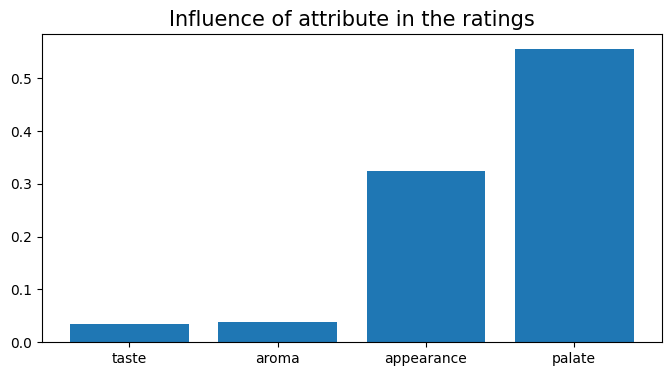

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          1.237e+08
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        19:10:21   Log-Likelihood:                     -2.4352e+06
No. Observations:             5419565   AIC:                                  4.870e+06
Df Residuals:                 5419561   BIC:                                  4.870e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [94]:
from sklearn import linear_model
import statsmodels.api as sm

X = combinde_ratings_df[['taste', 'aroma', 'appearance', 'palate']]
y = combinde_ratings_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['taste', 'aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

print(model.summary())

We observe that the attribute palate has the most substantial consequence on the rating, followed by appearance, aroma and taste.
Let's take a look now at the good reviews.

## Textual analysis

In [24]:
nlp = spacy.load('en_core_web_sm')

In [25]:
# drop rows where text is missing
good_ratings_combined_df.dropna(subset=['text'], inplace=True)
bad_ratings_combined_df.dropna(subset=['text'], inplace=True)

## Attribute analysis 

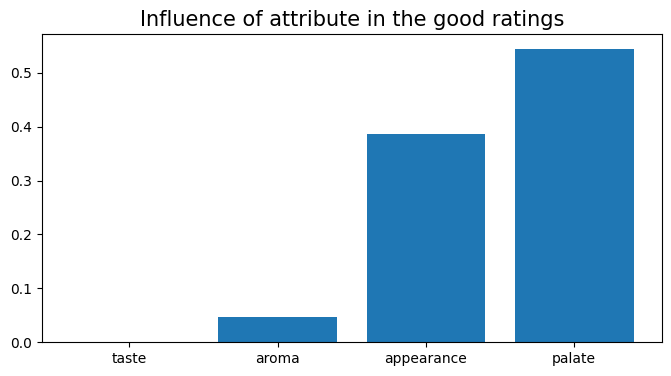

In [95]:
X = good_ratings_combined_df[['taste', 'aroma', 'appearance', 'palate']]
y = good_ratings_combined_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['taste', 'aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the good ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

We get the same result as before. To have more insights, let's look at the seasonality of the attributes. Do we observe any difference between the different months? 

## Attribute analysis by months

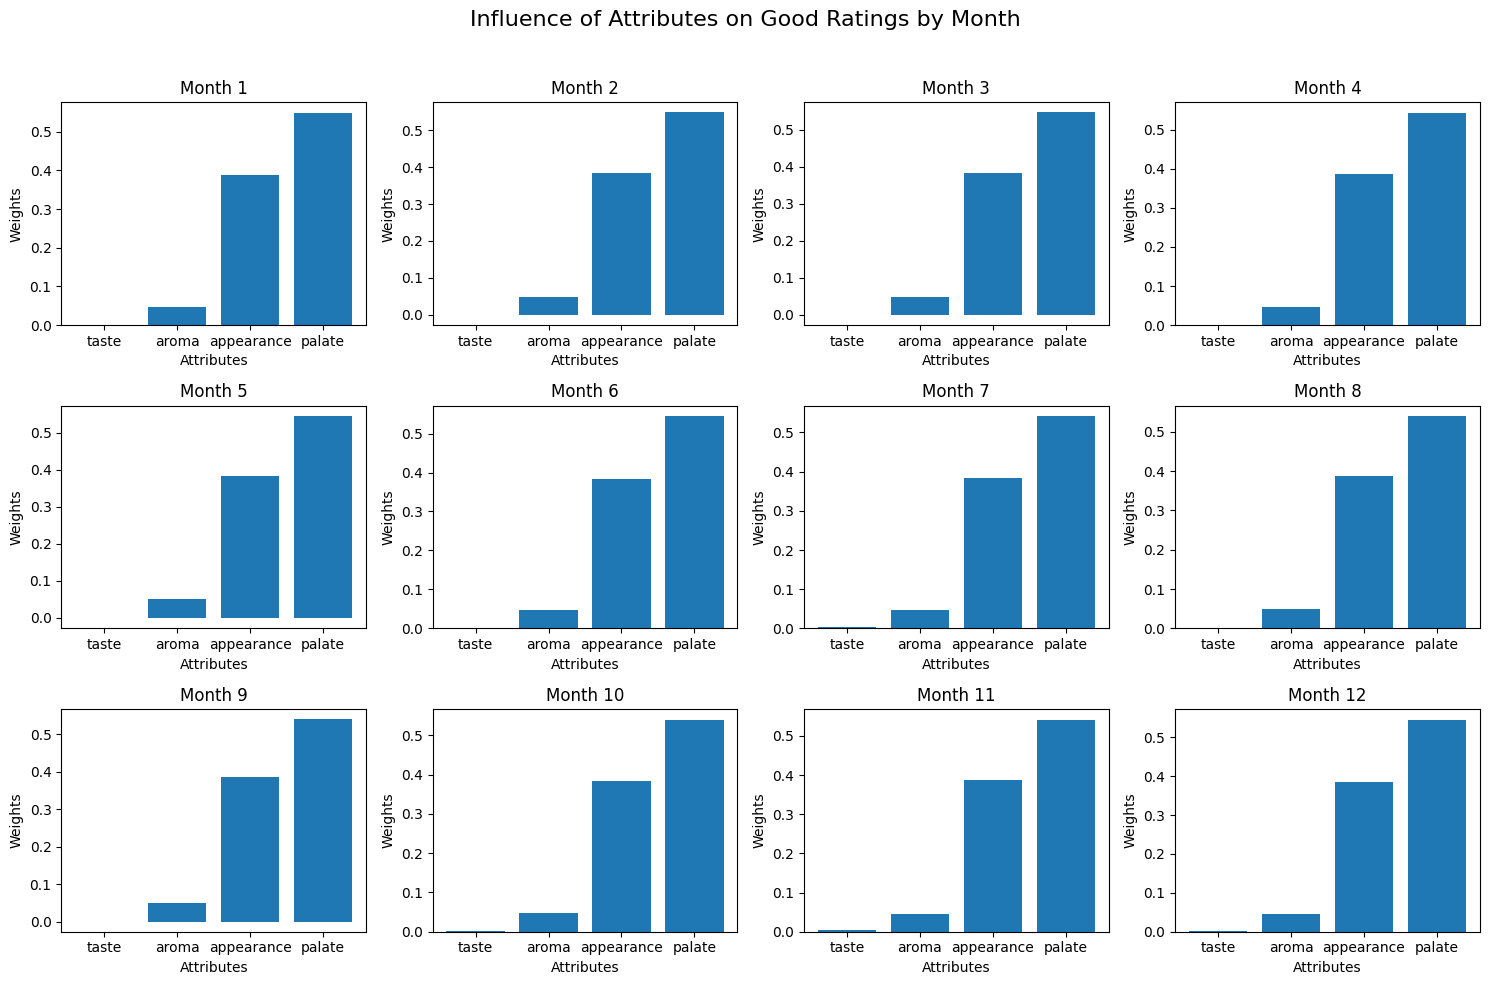

In [96]:
# List of months
months = sorted(good_ratings_combined_df['month'].unique())

# Set up subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Influence of Attributes on Good Ratings by Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

for i, month in enumerate(months):
    # Filter data for the current month
    month_df = good_ratings_combined_df[good_ratings_combined_df['month'] == month]
    
    # Define X and y for the current month
    X = month_df[['taste', 'aroma', 'appearance', 'palate']]
    y = month_df['rating']

    # Linear Regression
    clf = linear_model.LinearRegression(fit_intercept=False)
    clf.fit(X, y)
    weights = clf.coef_

    # Create a bar plot on the current subplot
    axes[i].bar(x=['taste', 'aroma', 'appearance', 'palate'], height=weights)
    axes[i].set_title(f'Month {month}')
    axes[i].set_xlabel('Attributes')
    axes[i].set_ylabel('Weights')
    axes[i].grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Keywords extraction of the good reviews

In [13]:
# Keywords for each category
aroma_keywords = ['aroma', 'smell', 'fragrance', 'scent', 'finish']
taste_keywords = ['taste', 'flavor', 'palate']
palate_keywords = ['palate', 'mouthfeel', 'body', 'texture', 'feel']
appearance_keywords = ['appearance', 'color', 'look', 'pour', 'head', 'foam', 'lacing']
carbonation_keywords = ['carbonation', 'bubbles', 'fizz', 'carbonated']

In [14]:
def extract_keywords(text, keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        if token.text.lower() in keywords:
            # Collect nearby adjectives and nouns
            nearby_words = []
            for nearby_token in doc[token.i - 3:token.i + 5]:
                if nearby_token.pos_ in ['ADJ', 'NOUN'] and not nearby_token.is_stop and len(nearby_token) > 2:
                    nearby_words.append(nearby_token.lemma_)
            result.extend(nearby_words)
            
    # remove the duplicates and the words that are in the keywords list
    result = list(set(result) - set(keywords))

    return result

In [15]:
# group by beer_id and count the number of reviews for each beer
beer_reviews_count = good_ratings_combined_df.groupby('beer_id').count()['text'].reset_index()

In [16]:
# print the average number of reviews
print("Average number of reviews per beer:", beer_reviews_count.text.mean())

Average number of reviews per beer: 13.480106777795909


In [17]:
beer_reviews_count.describe()

,beer_id,text
count,239001.000000,239001.000000
mean,221272.727223,13.480107
std,150582.412973,71.936676
min,1.000000,1.000000
25%,89204.000000,1.000000
50%,201842.000000,2.000000
75%,336505.000000,6.000000
max,536465.000000,4943.000000


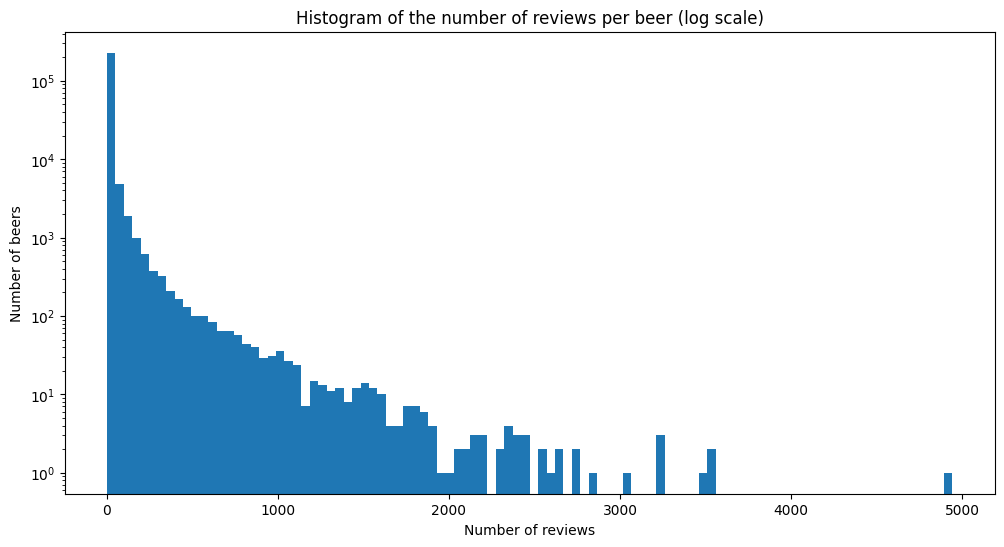

In [131]:
# plot histogram of the number of reviews with log scale
plt.figure(figsize=(12, 6))
plt.hist(beer_reviews_count.text, bins=100)
plt.xlabel('Number of reviews')
plt.ylabel('Number of beers')
plt.title('Histogram of the number of reviews per beer (log scale)')
plt.yscale('log')
plt.show()


The average of ratings received for a beer is 13.48, rounded to 14, with a standard deviation of 71.93. 
Since we have a lot of beers, and some of them receive a large amount of reviews, we decide to threshold the reviews. 
We assume that, in general, beers receive kind of the same review when it is a good review, and same goes for bad reviews. That's why we split the reviews into two parts, so that we can construct dictionnaries for good and for bad reviews.

Let's keep a maximum review of 100 for each beer. 

In [24]:
# for each beer_id, keep a maximum sample of mean reviews
mean = 14
beer_reviews_sample = good_ratings_combined_df.groupby('beer_id').apply(lambda x: x.sample(min(len(x), mean))).reset_index(drop=True)

In [25]:
len(beer_reviews_sample)

1028394

In [26]:
sample_reviews = beer_reviews_sample['text'].sample(100000)

In [ ]:
good_aroma_list = []
good_taste_list = []
good_palate_list = []
good_appearance_list = []
good_carbonation_list = []

sample_reviews = beer_reviews_sample['text'].sample(100000)

for i, text in enumerate(sample_reviews.values.tolist()):
    # for each keyword list, extract the keywords from the text
    good_aroma_list.extend(extract_keywords(text, aroma_keywords))
    good_taste_list.extend(extract_keywords(text, taste_keywords))
    good_palate_list.extend(extract_keywords(text, palate_keywords))
    good_appearance_list.extend(extract_keywords(text, appearance_keywords))
    good_carbonation_list.extend(extract_keywords(text, carbonation_keywords))
    
    aroma_set = Counter(good_aroma_list)
    taste_set = Counter(good_taste_list)
    palate_set = Counter(good_palate_list)
    appearance_set = Counter(good_appearance_list)
    carbonation_set = Counter(good_carbonation_list)
    
    if i % 1000 == 0:
        # save it into json files
        with open('data/aroma_keywords_2.json', 'w') as f:
            json.dump(aroma_set, f)
        
        with open('data/taste_keywords_2.json', 'w') as f:
            json.dump(taste_set, f)
        
        with open('data/palate_keywords_2.json', 'w') as f:
            json.dump(palate_set, f)
        
        with open('data/appearance_keywords_2.json', 'w') as f:
            json.dump(appearance_set, f)
        
        with open('data/carbonation_keywords_2.json', 'w') as f:
            json.dump(carbonation_set, f)
            
        print("File saved at iteration", i)

## Cleaning the list of keywords

In [14]:
# open the json files and load them into a dictionary
with open('data/aroma_keywords_2.json') as f:
    aroma_dict = json.load(f)

with open('data/taste_keywords_2.json') as f:
    taste_dict = json.load(f)
    
with open('data/palate_keywords_2.json') as f:
    palate_dict = json.load(f)

with open('data/appearance_keywords_2.json') as f:
    appearance_dict = json.load(f)
    
with open('data/carbonation_keywords_2.json') as f:
    carbonation_dict = json.load(f)

In [15]:
# concatenate all the keywords aroma_keywords, taste_keywords, palate_keywords, appearance_keywords, carbonation_keywords
all_keywords = aroma_keywords + taste_keywords + palate_keywords + appearance_keywords + carbonation_keywords

# create a function to filter the keys from the dictionary
def filter_keywords(keywords):
    filtered_keywords = []
    
    for keyword in keywords:
        
        # remove the keyowrds that have special characters, numbers and punctuation
        if not re.match('^[a-zA-Z]+$', keyword):
            continue
        
        # remove the keywords that are less than 3 characters
        if len(keyword) < 3:
            continue
        
        # remove keywords that have the word 'beer' in them
        if keyword == 'beer':
            continue
        
        # remove keywords such as not, like, well, etc.
        if keyword in ['not', 'one', 'like', 'well', 'good', 'great', 'nice', 'little', 'much', 'really', 'bit', 'very', 'with', 'more', 'and', 'but', 'too', 'also', 'just']:
            continue
        
        # remove words such as hop, hoppy, malt, malty, etc.
        if keyword in ['hop', 'hops', 'hoppy', 'malt', 'malts', 'malty', 'maltiness', 'maltinesses']:
            continue
        
        # if the keyword is not in the all_keywords list, add it to the filtered_keywords list
        if keyword not in all_keywords:
            filtered_keywords.append(keyword)
    
    return filtered_keywords

In [16]:
# filter the keywords
aroma_words = filter_keywords(aroma_dict.keys())
taste_words = filter_keywords(taste_dict.keys())
palate_words = filter_keywords(palate_dict.keys())
appearance_words = filter_keywords(appearance_dict.keys())
carbonation_words = filter_keywords(carbonation_dict.keys())

# reconstruct the dictionaries with the filtered keywords
aroma_dict = {key: aroma_dict[key] for key in aroma_words}
taste_dict = {key: taste_dict[key] for key in taste_words}
palate_dict = {key: palate_dict[key] for key in palate_words}
appearance_dict = {key: appearance_dict[key] for key in appearance_words}
carbonation_dict = {key: carbonation_dict[key] for key in carbonation_words}


In [17]:
# sort the dictionaries by value
aroma_dict = dict(sorted(aroma_dict.items(), key=lambda item: item[1], reverse=True))
taste_dict = dict(sorted(taste_dict.items(), key=lambda item: item[1], reverse=True))
palate_dict = dict(sorted(palate_dict.items(), key=lambda item: item[1], reverse=True))
appearance_dict = dict(sorted(appearance_dict.items(), key=lambda item: item[1], reverse=True))
carbonation_dict = dict(sorted(carbonation_dict.items(), key=lambda item: item[1], reverse=True))

In [18]:
# print the size of each dictionary
print("Number of aroma keywords:", len(aroma_dict))
print("Number of taste keywords:", len(taste_dict))
print("Number of palate keywords:", len(palate_dict))
print("Number of appearance keywords:", len(appearance_dict))
print("Number of carbonation keywords:", len(carbonation_dict))

Number of aroma keywords: 5263
Number of taste keywords: 5513
Number of palate keywords: 4444
Number of appearance keywords: 5760
Number of carbonation keywords: 2740


In [15]:
# keep only the keywords that appear more than 100 times
#appearance_dict = {k: v for k, v in appearance_dict.items() if v > 100}

# list of words to remove from the dictionary
appearance_terms = ['white', 'brown', 'light', 'small', 'thin', 'dark', 'golden', 'retention', 'medium', 'hazy', 'clear', 
                            'amber', 'black', 'creamy', 'thick', 'beige', 'orange', 'yellow', 'tan', 'foamy', 'copper', 'big', 
                            'gold', 'decent', 'deep', 'cloudy', 'lace', 'moderate', 'red', 'minimal', 
                            'ring', 'bright', 'colored', 'straw', 'dense', 'reddish', 'pale', 'khaki', 
                            'slight', 'rich', 'huge', 'fizzy', 'frothy', 'solid', 'average', 
                            'short', 'bubble', 'caramel', 'soft', 'pink', 'mocha', 'opaque', 'murky', 'ruby',
                            'rocky', 'fine', 'cling', 'cap', 'mahogany', 'brownish', 'ton', 'hue',  
                            'haze', 'pitch', 'clarity', 'wispy', 'cherry', 'highlight', 'clean', 'fade', 'funky', 
                            'ivory', 'purple', 'lacy', 'bone', 'high', 'hint', 'pinkish', 'peach', 'toffee',  'yellowish', 
                            'patchy', 'bronze', 'muddy', 'firm', 'clingy', 'stringy', 'visible', 'transparent']

In [16]:
#taste_dict = {k: v for k, v in taste_dict.items() if v > 100}

taste_terms = ['sweet',  'bitter', 'smooth', 'roasted', 'dry', 'fruity', 'tart', 'bodied', 
    'bitterness', 'sour', 'strong', 'spice', 'mild', 'rich',  'yeast', 'profile', 'sweetness', 'earthy', 'balanced', 'alcohol', 
    'wheat', 'spicy', 'clean', 'moderate', 'crisp', 'grain', 'slight', 'heavy',
    'creamy', 'mid', 'complex', 'hint', 'roasty', 'bready', 'bread', 'roast', 'herbal', 'fresh', 'sugar', 'balance', 
    'solid', 'soft', 'juicy', 'subtle', 'grass', 'grassy', 'smoke',
    'funk', 'nutty', 'character', 'refreshing', 'citrusy', 'belgian', 'decent', 'bittersweet', 
    'rye', 'thick', 'thin', 'piney', 'grainy', 'clove', 'yeasty', 
    'wine', 'molasse', 'ale', 'biscuit', 'funky', 'bud', 'plenty', 'peppery', 'milk', 'barrel', 'tartness', 
    'smoky', 'woody', 'faint', 'toast', 'low', 'stout', 
    'ester', 'ton', 'bold', 'intense', 'deep', 'suit', 'brew', 'tangy', 'whiskey', 'blend', 'peel', 
    'tasty', 'ipa', 'acidic', 'straw', 'boozy', 'fruitiness', 'smokey', 'mellow', 'earthiness', 'juice', 'toasty', 'booze', 
    'average', 'tone', 'dough', 'robust', 'sourness', 'cracker', 'noticeable', 'biscuity', 
    'rind', 'barley', 'lager', 'cream', 'plum', 'acidity',  'hoppiness', 'upfront', 
    'resinous', 'syrup', 'porter', 'vinegar', 'sugary',' bubblegum']


In [17]:
#palate_dict = {k: v for k, v in palate_dict.items() if v > 100}

palate_terms = ['medium', 'light', 'smooth', 'creamy', 'dry', 'bodied', 'soft', 'thin', 'thick', 'moderate', 'crisp',  'sticky', 'slick', 
                'mid', 'solid', 'decent', 'mild', 'balanced', 'oily', 'chewy', 'deep', 'watery', 'silky', 'refreshing', 'strong', 'touch', 'balance', 'fizzy', 'character', 
                'fine', 'flat', 'full', 'hint', 'sharp', 'bready', 'foamy', 'viscous', 'chalky', 'effervescent', 'fluffy', 'grainy', 'gentle', 
                'prickly', 'tartness', 'bubbly', 'acidic', 'astringency']

In [18]:
#aroma_dict = {k: v for k, v in aroma_dict.items() if v > 100}

aroma_terms = ['citrus', 'chocolate', 'fruit', 'fruity', 'coffee',  'floral',
    'caramel', 'pine', 'grapefruit', 'tropical', 'vanilla', 'lemon', 'bourbon', 'cherry', 
    'orange', 'herbal', 'decent', 'citrusy', 'cocoa', 'honey', 'oak', 
    'toffee', 'nutty', 'banana', 'grass', 'apple', 
    'pepper', 'pineapple', 'thin', 'funk', 'clove', 'wood', 
    'berry', 'woody', 'biscuit', 'raspberry', 'grape', 'molasse', 'tangy', 'barrel', 'peach', 'raisin', 'resinous', 
    'candy', 'ipa',  'nut', 'pungent', 'pumpkin', 'ginger', 
    'mango', 'warming', 'earth', 'mellow', 'cereal', 'ring', 'astringent', 
    'coriander', 'tangerine', 'maple', 'melon', 'hay', 'lactic', 'citric', 'peel', 'rind', 'lager', 'bold', 'vinous', 'weak', 'toasted', 'blueberry', 
    'biscuity', 'spiced', 'lime', 'metallic', 'coconut', 'hay'
]

In [19]:
def matching_keywords(text, list_keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        token = token.lemma_
        if token in list_keywords:
            result.append(token)
    
    return result

## Using the lower bound of Wilson to select the best beer

In [ ]:
def find_top_keywords_by_month(df, keywords_list, month, category, num_keywords):
    # Filter the DataFrame for the specified month
    month_df = df[df['month'] == month]

    # Find the best beer for the month based on average rating and review count
    #best_beer_df = month_df.groupby('beer_id').agg({category: ['mean', 'count']}).reset_index()
    #best_beer_df.columns = ['beer_id', 'average_rating', 'review_count']
    #beer_stats = best_beer_df.sort_values(by=['review_count', 'average_rating'], ascending=[False, False])

    # Get the beer ID of the best beer for the month
    #best_beer_id = beer_stats.iloc[0]['beer_id']
    
    best_beer_id = get_wilson_beers(month_df, category, n=10)
    
    # print the best beer id for the month
    print(f"Best beer for the month of {month}:", best_beer_id)

    # filter the dataframe with the 10 best beers for the month
    best_beer_reviews = month_df[month_df['beer_id'].isin(best_beer_id)]

    # Extract keywords from reviews using a matching function (e.g., matching_keywords)
    keyword_list = []
    for text in best_beer_reviews['text'].values.tolist():
        keyword_list.extend(matching_keywords(text, keywords_list))

    # Count the number of times each keyword appears in the reviews
    keyword_counter = Counter(keyword_list)

    # Sort the dictionary by value
    sorted_keywords = dict(sorted(keyword_counter.items(), key=lambda item: item[1], reverse=True))

    # Return the top N keywords as a list of tuples (key, value)
    top_keywords = [(key, sorted_keywords[key]) for key in list(sorted_keywords.keys())[:num_keywords]]

    return top_keywords

In [26]:
def find_top_keywords_by_month_traditional(df, keywords_list, month, category, num_keywords):
    # Filter the DataFrame for the specified month
    month_df = df[df['month'] == month]

    #Find the best beer for the month based on average rating and review count
    best_beer_df = month_df.groupby('beer_id').agg({category: ['mean', 'count']}).reset_index()
    best_beer_df.columns = ['beer_id', 'average_rating', 'review_count']
    beer_stats = best_beer_df.sort_values(by=['review_count', 'average_rating'], ascending=[False, False])

    #Get the beer ID of the best beer for the month
    best_beer_id = beer_stats.iloc[0]['beer_id']
    
    #best_beer_id = get_wilson_beers(month_df, category, n=10)
    
    # print the best beer id for the month
    print(f"Best beer for the month of {month}:", best_beer_id)

    # filter the dataframe with the 10 best beers for the month
    best_beer_reviews = month_df[month_df['beer_id'] == best_beer_id]

    # Extract keywords from reviews using a matching function (e.g., matching_keywords)
    keyword_list = []
    for text in best_beer_reviews['text'].values.tolist():
        keyword_list.extend(matching_keywords(text, keywords_list))

    # Count the number of times each keyword appears in the reviews
    keyword_counter = Counter(keyword_list)

    # Sort the dictionary by value
    sorted_keywords = dict(sorted(keyword_counter.items(), key=lambda item: item[1], reverse=True))

    # Return the top N keywords as a list of tuples (key, value)
    top_keywords = [(key, sorted_keywords[key]) for key in list(sorted_keywords.keys())[:num_keywords]]

    return top_keywords

## Aroma analysis 

In [156]:
# for each month, find the top 10 keywords
top_keywords_by_month = {}
for month in range(1, 13):
    top_keywords_by_month[month] = find_top_keywords_by_month(good_ratings_combined_df, aroma_terms, month, 'aroma', 10)
    print("Month", month)
    print(top_keywords_by_month[month])
    print()

      beer_id  aroma  count  above_average  below_average  lower_bound
4425     8909    8.5    266            266              0     0.985764
Best beer for the month of 1: 8909
Month 1
[('bourbon', 390), ('chocolate', 233), ('vanilla', 187), ('coffee', 96), ('caramel', 77), ('oak', 71), ('fruit', 49), ('molasse', 46), ('barrel', 44), ('wood', 42)]

      beer_id     aroma  count  above_average  below_average  lower_bound
4293     8936  8.764045    178            177              1     0.968868
Best beer for the month of 2: 8936
Month 2
[('pine', 97), ('citrus', 82), ('grapefruit', 70), ('orange', 55), ('ipa', 50), ('floral', 33), ('fruit', 25), ('caramel', 21), ('citrusy', 15), ('fruity', 13)]

      beer_id     aroma  count  above_average  below_average  lower_bound
4011     7686  8.428571     84             84              0     0.956268
Best beer for the month of 3: 7686
Month 3
[('raspberry', 152), ('fruit', 42), ('fruity', 15), ('berry', 12), ('thin', 9), ('cherry', 7), ('oak', 5)

In [27]:
# for each month, find the top 10 keywords
top_keywords_by_month = {}
for month in range(1, 13):
    top_keywords_by_month[month] = find_top_keywords_by_month_traditional(good_ratings_combined_df, aroma_terms, month, 'aroma', 10)
    print("Month", month)
    print(top_keywords_by_month[month])
    print()

Best beer for the month of 1: 17112.0
Month 1
[('honey', 1048), ('citrus', 692), ('grapefruit', 637), ('orange', 546), ('pine', 457), ('ipa', 319), ('fruit', 257), ('pineapple', 254), ('floral', 236), ('tropical', 162)]

Best beer for the month of 2: 17112.0
Month 2
[('honey', 934), ('citrus', 662), ('grapefruit', 554), ('orange', 522), ('pine', 429), ('ipa', 388), ('fruit', 232), ('floral', 229), ('pineapple', 202), ('tropical', 164)]

Best beer for the month of 3: 15881.0
Month 3
[('citrus', 346), ('pine', 274), ('caramel', 243), ('orange', 234), ('grapefruit', 233), ('ipa', 159), ('floral', 143), ('fruit', 110), ('citrusy', 80), ('fruity', 80)]

Best beer for the month of 4: 19960.0
Month 4
[('bourbon', 1498), ('coffee', 1407), ('chocolate', 1183), ('vanilla', 725), ('oak', 342), ('barrel', 296), ('thin', 192), ('caramel', 132), ('molasse', 78), ('cocoa', 72)]

Best beer for the month of 5: 19960.0
Month 5
[('bourbon', 690), ('coffee', 607), ('chocolate', 511), ('vanilla', 296), ('o

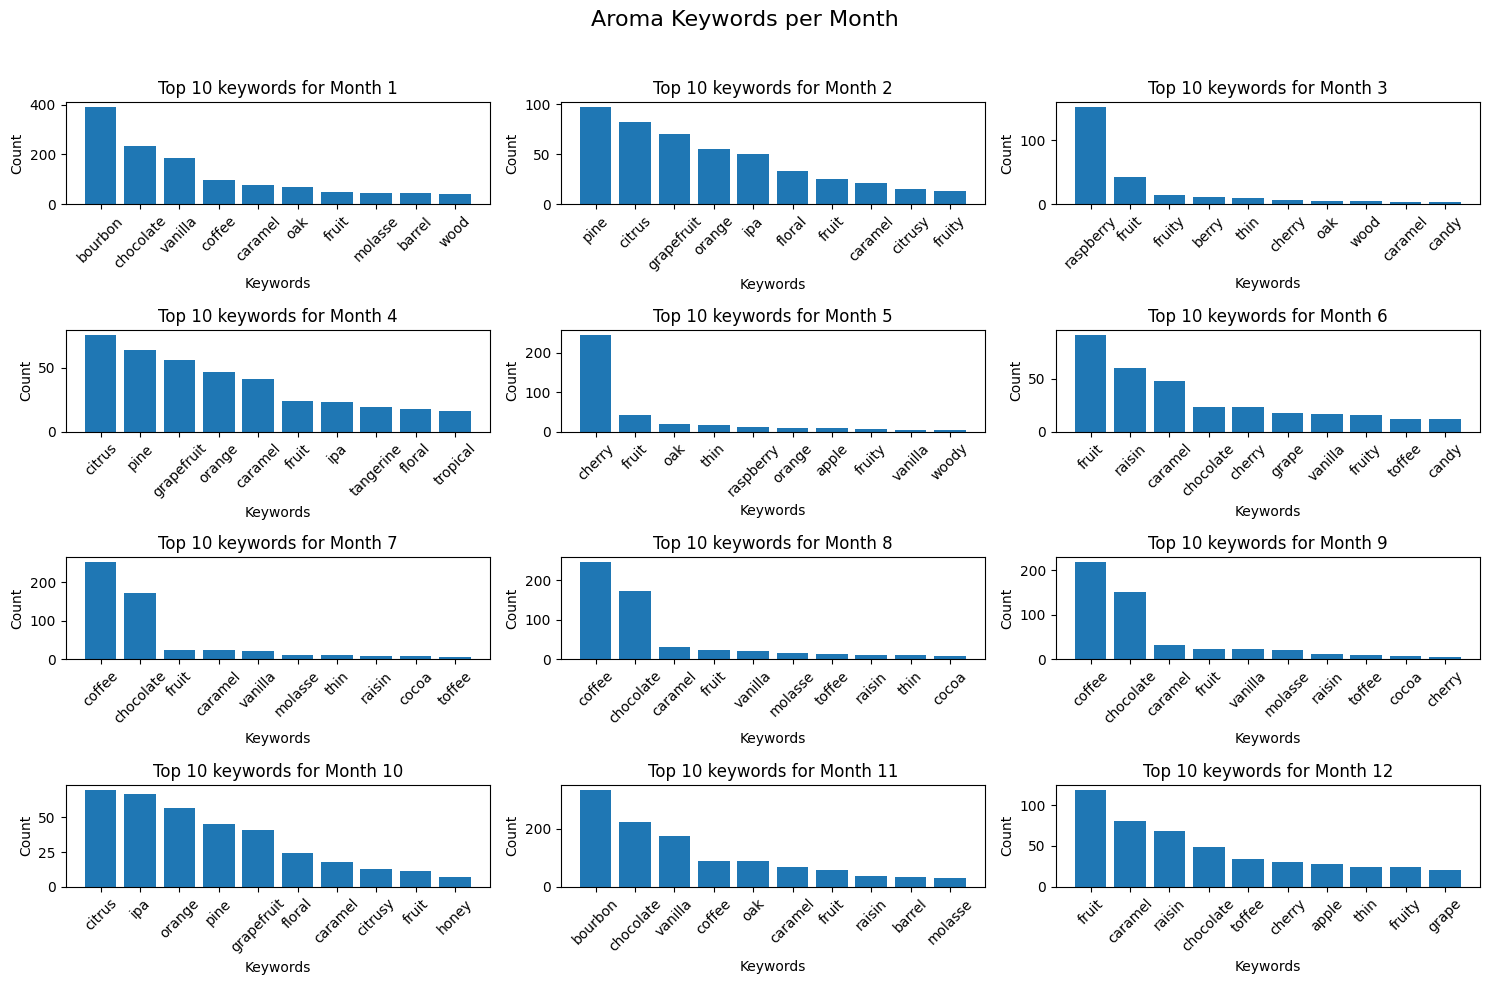

In [157]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Aroma Keywords per Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

# Iterate over each key and create a subplot
for i, (key, data) in enumerate(top_keywords_by_month.items()):
    keywords, values = zip(*data)

    # Create a bar plot on the current subplot
    axes[i].bar(keywords, values)
    axes[i].set_title(f'Top 10 keywords for Month {key}')
    axes[i].set_xlabel('Keywords')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Taste analysis

In [160]:
# for each month, find the top 10 keywords
top_keywords_by_month_taste = {}
for month in range(1, 13):
    top_keywords_by_month_taste[month] = find_top_keywords_by_month(good_ratings_combined_df, taste_terms, month, 'taste', 10)
    print("Month", month)
    print(top_keywords_by_month_taste[month])
    print()

      beer_id     taste  count  above_average  below_average  lower_bound
2811     4934  9.046512    172            172              0     0.978154
Best beer for the month of 1: 4934
Month 1
[('alcohol', 110), ('sweet', 86), ('sugar', 55), ('complex', 53), ('yeast', 53), ('smooth', 45), ('plum', 38), ('deep', 33), ('dry', 32), ('belgian', 31)]

      beer_id     taste  count  above_average  below_average  lower_bound
2783     4934  9.198198    111            111              0      0.96655
Best beer for the month of 2: 4934
Month 2
[('sweet', 61), ('alcohol', 53), ('complex', 35), ('smooth', 35), ('yeast', 34), ('sugar', 29), ('plum', 28), ('rich', 23), ('creamy', 23), ('dry', 18)]

      beer_id     taste  count  above_average  below_average  lower_bound
2845     4934  8.948387    155            155              0     0.975816
Best beer for the month of 3: 4934
Month 3
[('alcohol', 85), ('sweet', 81), ('complex', 55), ('plum', 48), ('sugar', 45), ('smooth', 37), ('spice', 33), ('cream

In [28]:
# for each month, find the top 10 keywords
top_keywords_by_month_taste = {}
for month in range(1, 13):
    top_keywords_by_month_taste[month] = find_top_keywords_by_month_traditional(good_ratings_combined_df, taste_terms, month, 'taste', 10)
    print("Month", month)
    print(top_keywords_by_month_taste[month])
    print()

Best beer for the month of 1: 17112.0
Month 1
[('sweet', 660), ('alcohol', 506), ('bitter', 407), ('sweetness', 404), ('bitterness', 385), ('smooth', 322), ('ipa', 319), ('balance', 284), ('fresh', 249), ('brew', 216)]

Best beer for the month of 2: 17112.0
Month 2
[('sweet', 650), ('alcohol', 446), ('sweetness', 390), ('ipa', 388), ('bitter', 383), ('bitterness', 358), ('smooth', 315), ('balance', 263), ('strong', 206), ('brew', 198)]

Best beer for the month of 3: 15881.0
Month 3
[('sweet', 335), ('bitter', 217), ('bitterness', 214), ('balance', 192), ('smooth', 179), ('ipa', 159), ('sweetness', 158), ('brew', 134), ('strong', 127), ('piney', 123)]

Best beer for the month of 4: 19960.0
Month 4
[('stout', 638), ('alcohol', 395), ('thick', 363), ('smooth', 362), ('sweet', 301), ('barrel', 296), ('roasted', 289), ('hint', 249), ('strong', 243), ('creamy', 212)]

Best beer for the month of 5: 19960.0
Month 5
[('stout', 240), ('alcohol', 203), ('thick', 163), ('smooth', 135), ('roasted',

## Palate analysis 

In [161]:
# for each month, find the top 10 keywords
top_keywords_by_month_palate = {}
for month in range(1, 13):
    top_keywords_by_month_palate[month] = find_top_keywords_by_month(good_ratings_combined_df, palate_terms, month, 'palate', 10)
    print("Month", month)
    print(top_keywords_by_month_palate[month])
    print()

      beer_id    palate  count  above_average  below_average  lower_bound
6612    16814  4.717105    228            226              2     0.968586
Best beer for the month of 1: 16814
Month 1
[('medium', 56), ('light', 56), ('smooth', 45), ('balance', 38), ('strong', 34), ('dry', 30), ('hint', 29), ('creamy', 28), ('balanced', 28), ('full', 26)]

      beer_id    palate  count  above_average  below_average  lower_bound
7350    21690  4.706776    428            425              3     0.979597
Best beer for the month of 2: 21690
Month 2
[('smooth', 161), ('light', 148), ('balance', 140), ('balanced', 118), ('medium', 115), ('full', 102), ('strong', 99), ('dry', 97), ('sticky', 80), ('thick', 71)]

      beer_id    palate  count  above_average  below_average  lower_bound
7428    19960  4.555389    501            491             10     0.963652
Best beer for the month of 3: 19960
Month 3
[('thick', 278), ('smooth', 270), ('creamy', 170), ('strong', 164), ('light', 162), ('hint', 144), ('th

## Appearance analysis

In [162]:
# for each month, find the top 10 keywords
top_keywords_by_month_appearance = {}
for month in range(1, 13):
    top_keywords_by_month_appearance[month] = find_top_keywords_by_month(good_ratings_combined_df, appearance_terms, month, 'appearance', 10)
    print("Month", month)
    print(top_keywords_by_month_appearance[month])
    print()

       beer_id  appearance  count  above_average  below_average  lower_bound
10613    34420    4.619601    301            299              2     0.976101
Best beer for the month of 1: 34420
Month 1
[('dark', 405), ('black', 300), ('thick', 178), ('brown', 132), ('creamy', 114), ('hint', 113), ('big', 103), ('light', 95), ('rich', 80), ('tan', 71)]

      beer_id  appearance  count  above_average  below_average  lower_bound
9934    34420    4.602018    223            222              1     0.975041
Best beer for the month of 2: 34420
Month 2
[('dark', 292), ('black', 240), ('thick', 124), ('brown', 98), ('light', 94), ('creamy', 93), ('hint', 77), ('rich', 76), ('big', 75), ('tan', 71)]

       beer_id  appearance  count  above_average  below_average  lower_bound
10590    34420    4.599398    166            165              1     0.966671
Best beer for the month of 3: 34420
Month 3
[('dark', 221), ('black', 154), ('thick', 83), ('hint', 64), ('light', 63), ('brown', 63), ('creamy', 56),